## **¿Cuáles son los factores que afectan el precio del trigo en Argentina y cómo predecirlo?**
Este trabajo investiga cómo el precio del trigo en Argentina está influenciado por varios factores, como el precio global del trigo, el precio del petróleo, las condiciones climáticas y el tipo de cambio USD/ARS, y luego se utilizan modelos de machine learning, como Random Forest y Ridge Regression, para predecir el precio del trigo basándose en estos factores.



En el contexto del mercado agrícola actual, es fundamental contar con herramientas que faciliten la comprensión de los factores que influyen en la variabilidad del precio de los commodities. Tanto los **productores agrícolas como los inversores** se beneficiarían al entender los elementos que afectan el precio del trigo y si es posible en base a ellos, predecir su valor en el mercado. Este conocimiento les permitiría desarrollar estrategias efectivas en la producción y comercialización, así como tomar decisiones de inversión más fundamentadas.

Este proyecto se enfoca en analizar y modelar el **precio del trigo** en relación con cuatro factores clave:

**Precio del petróleo**: Evaluar cómo las fluctuaciones en el precio del petróleo impactan el costo de producción y, por ende, el precio del trigo.

**Precio del trigo global**: Investigar la correlación entre el precio del trigo en Argentina y el precio del trigo en mercados globales.

**Condiciones climáticas:** Analizar cómo los factores climaticos y estacionales afectan la oferta y demanda del trigo en Argentina.

**Tipo de cambio:** Examinar cómo las variaciones en el tipo de cambio influyen en el precio del trigo en dólares. Un peso argentino más débil frente al dólar puede aumentar los costos de produccion

Preguntas a Responder

**¿Varía el precio del trigo en función de las condiciones climáticas?**

**¿El precio del trigo se ve impactado directamente por el valor del petróleo?**

**¿Existe una correlación significativa entre el precio global del trigo y el precio del trigo en Argentina?**



**Contexto analítico**


Este data frame se compone de diversas fuentes de datos que han sido fusionadas para el posterior analisis, asi como variables calculadas que fueron agregadas para una vision mas clara. *Creando un data frame total de 7348 filas y 16 columnas.*

Los datos obtenidos son:

**Histórico de precios del trigo:** Datos del precio del trigo en argentina desde 2017 hasta 2024 obtenidos del BCR (Banco central de rosario).

**Datos climáticos:** Información proporcionada por la api METEOSTAT sobre la condicion del clima en las principales regiones productoras de trigo del país.

**Precios del petróleo:** Datos sobre el precio del petróleo a lo largo del período analizado en ARGENTINA, obtenido con la API libreria que interactua con la api de yahoo finance.

**Precios del petróleo GLOBAL** : Datos sobre el precio del petróleo a nivel mundial a lo largo del período analizado

**Datos del dólar oficial:** Informacion sobre el tipo de cambio del dólar oficial en Argentina durante el mismo período, recolectada de yahoo finance.

Las variables que conforman el data frame final son:

**Fecha**: Fecha de observación.

**Precio**: Precio del trigo en pesos argentinos.

**Precio_en_usd**: Precio del trigo en dólares estadounidenses.

**Precio_petroleo**: Precio del petróleo en dólares.

**tavg**: Temperatura promedio.

**tmin**: Temperatura mínima.

**tmax**: Temperatura máxima.

**prcp**: Precipitación en milímetros.

**wdir**: Dirección del viento.

**wspd**: Velocidad del viento.

**pres**: Presión atmosférica.

**Estacion**: Variable calculada para definir estaciones climáticas.

**Region:** Variable calculada para determinar el clima por región.

**Estacion**: Variable calculada para definir estaciones climáticas.

**categoria_prcp**: Categoría de precipitación (Baja, Media, Alta).

**categoria_temp**: Categoría de temperatura (Baja, Media, Alta).

# **Se realiza la carga y limpieza de distintas fuentes de datos**

In [1]:
pip install meteostat #Se instala la libreria que consulta la api de meteostat para descargar datos del clima

In [2]:
from meteostat import Point, Daily
from datetime import datetime
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

**Precios del trigo en ARS**


In [3]:
url = 'https://github.com/Melanydaian/preentrega_Ds_amarillo/raw/main/preciostrigo2017.xlsx'
df_trigo = pd.read_excel(url)

print(df_trigo.head())
print(df_trigo.info())



            Unnamed: 0 Unnamed: 1 Unnamed: 2  Consulta de precios
0                  NaN        NaN        NaN                  NaN
1                  NaN        NaN        NaN                  NaN
2                Trigo        NaN        NaN                  NaN
3   Fecha de operación        NaN     Precio                  NaN
4  2017-01-02 10:12:00        NaN       2480                  NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1888 non-null   object 
 1   Unnamed: 1           430 non-null    object 
 2   Unnamed: 2           1887 non-null   object 
 3   Consulta de precios  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 59.2+ KB
None


In [4]:
#Se renombran las columnas relevantes
df_trigo.rename(columns={'Unnamed: 0': 'fecha', 'Unnamed: 2': 'precio'}, inplace=True)

#Se eliminan columnas innecesarias
df_trigo_clean = df_trigo[['fecha', 'precio']]

#Se eliminan las filas donde 'fecha' no es una fecha válida
df_trigo_clean = df_trigo_clean[df_trigo_clean['precio'].apply(lambda x: str(x).isdigit())]

#Se convierte la columna de fecha a tipo datetime
df_trigo_clean['fecha'] = pd.to_datetime(df_trigo_clean['fecha'], errors='coerce')
df_trigo_clean['precio'] = pd.to_numeric(df_trigo_clean['precio'], errors='coerce') #el precio a tipo numerico
df_trigo_clean['fecha'] = df_trigo_clean['fecha'].dt.date
print("\nPrimeras filas de df_trigo_clean después de ajustar las fechas:")
print(df_trigo_clean.head())
print("\nInformación final de df_trigo_clean:")
print(df_trigo_clean.info())



Primeras filas de df_trigo_clean después de ajustar las fechas:
        fecha  precio
4  2017-01-02    2480
5  2017-01-03    2490
6  2017-01-04    2495
7  2017-01-05    2495
8  2017-01-06    2495

Información final de df_trigo_clean:
<class 'pandas.core.frame.DataFrame'>
Index: 1886 entries, 4 to 1889
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fecha   1886 non-null   object
 1   precio  1886 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.2+ KB
None


**Datos del clima**

In [5]:
#Se obtienen datos del período de tiempo 2017 - 2024 de las principales regiones productoras de trigo en Argentina
start = datetime(2017, 1, 1)
end = datetime(2024, 12, 31)
regiones_trigo = {
    "Buenos Aires": Point(-34.6037, -58.3816, 25),
    "Córdoba": Point(-31.4201, -64.1888, 400),
    "Santa Fe": Point(-31.6097, -60.7000, 20),
    "La Pampa": Point(-36.6167, -64.2833, 200),
}

# Se crea un DataFrame vacío para almacenar los datos climáticos
df_clima_trigo = pd.DataFrame()

# Se recopilan los datos climáticos para cada región
for region, punto in regiones_trigo.items():
    try:
        # Se obtienen los datos climáticos diarios
        data = Daily(punto, start, end)
        data = data.fetch()

        # Se eliminan las columnas que contienen solo valores nulos
        data = data.dropna(axis=1, how='all')

        # Se agrega el nombre de la región para identificar los datos
        data['region'] = region
        if not data.empty:
            df_clima_trigo = pd.concat([df_clima_trigo, data])

    except Exception as e:
        print(f"Error al obtener datos para {region}: {e}")

print(df_clima_trigo.head())
print(df_clima_trigo.info())
print(f"Número total de registros: {df_clima_trigo.shape[0]}")


            tavg  tmin  tmax  prcp  snow   wdir  wspd    pres        region  \
time                                                                          
2017-01-01  30.2  27.4  34.9   0.0   NaN  232.0  11.1  1007.9  Buenos Aires   
2017-01-02  25.5  20.9  33.9   NaN   NaN  114.0  21.9  1011.8  Buenos Aires   
2017-01-03  26.1  23.6  28.3   NaN   NaN    3.0  14.9  1003.8  Buenos Aires   
2017-01-04  26.1  22.2  30.9   NaN   NaN  230.0   7.0  1004.6  Buenos Aires   
2017-01-05  25.0  19.6  30.7   NaN   NaN    NaN   9.9     NaN  Buenos Aires   

            wpgt  
time              
2017-01-01   NaN  
2017-01-02   NaN  
2017-01-03   NaN  
2017-01-04   NaN  
2017-01-05   NaN  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11605 entries, 2017-01-01 to 2024-12-11
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    11599 non-null  float64
 1   tmin    11501 non-null  float64
 2   tmax    10948 non-null  float64
 3

In [6]:
#Se eliminan columnas con demasiados valores nulos en el DataFrame de clima
df_clima_trigo.drop(columns=['snow', 'wpgt'], inplace=True)

#Se rellenan los valores nulos restantes utilizando interpolación lineal
df_clima_trigo.interpolate(method='linear', inplace=True)
df_clima_trigo.reset_index(inplace=True)

#Se verifica la limpieza de los datos mostrando la cantidad de valores nulos restantes
print("\nValores nulos después de la limpieza:")
print(df_clima_trigo.isnull().sum())

#Se muestran las primeras filas del DataFrame limpio
print("\nDataFrame limpio:")
print(df_clima_trigo.head())






Valores nulos después de la limpieza:
time      0
tavg      0
tmin      0
tmax      0
prcp      0
wdir      0
wspd      0
pres      0
region    0
dtype: int64

DataFrame limpio:
        time  tavg  tmin  tmax       prcp   wdir  wspd    pres        region
0 2017-01-01  30.2  27.4  34.9   0.000000  232.0  11.1  1007.9  Buenos Aires
1 2017-01-02  25.5  20.9  33.9   4.285714  114.0  21.9  1011.8  Buenos Aires
2 2017-01-03  26.1  23.6  28.3   8.571429    3.0  14.9  1003.8  Buenos Aires
3 2017-01-04  26.1  22.2  30.9  12.857143  230.0   7.0  1004.6  Buenos Aires
4 2017-01-05  25.0  19.6  30.7  17.142857  136.5   9.9  1009.9  Buenos Aires


In [7]:
#Se renombra y convierte la columna fecha a formato date
df_trigo_clean['fecha'] = pd.to_datetime(df_trigo_clean['fecha']).dt.date
df_clima_trigo['fecha'] = pd.to_datetime(df_clima_trigo['time']).dt.date

#Se elimina la columna 'time' ya que ahora se cuenta con la columna 'fecha'
df_clima_trigo.drop(columns=['time'], inplace=True)

#Se realiza el merge (inner join) de los datos climáticos con los precios de trigo basados en la columna de fecha
df_combined = pd.merge(df_trigo_clean, df_clima_trigo, on='fecha', how='inner')

print(df_combined.head())

# Se verifica cuántas fechas comunes se encontraron
fechas_comunes = len(df_combined)
print(f"Fechas comunes encontradas: {fechas_comunes}")




        fecha  precio  tavg  tmin  tmax      prcp        wdir       wspd  \
0  2017-01-02    2480  25.5  20.9  33.9  4.285714  114.000000  21.900000   
1  2017-01-02    2480  23.8  19.5  28.6  0.300000  326.000000   8.300000   
2  2017-01-02    2480  23.7  21.9  26.3  5.100000    9.141582  17.088520   
3  2017-01-02    2480  24.3  15.5  32.7  8.000000  164.586690  10.040981   
4  2017-01-03    2490  26.1  23.6  28.3  8.571429    3.000000  14.900000   

          pres        region  
0  1011.800000  Buenos Aires  
1  1011.000000       Córdoba  
2  1011.784311      Santa Fe  
3  1015.098949      La Pampa  
4  1003.800000  Buenos Aires  
Fechas comunes encontradas: 7544


In [8]:
pip install yfinance

**Tipo de cambio**

In [9]:
#Se descargan datos históricos de USD/ARS desde 2017 hasta 2024
df_usd_ars = yf.download('ARS=X', start='2017-01-01', end='2024-12-31')
df_usd_ars.reset_index(inplace=True)
if isinstance(df_usd_ars.columns, pd.MultiIndex):
    print("Detectado MultiIndex, ajustando columnas...")
    df_usd_ars.columns = df_usd_ars.columns.map('_'.join).str.strip('_')

#Se renombrar columnas relevantes
df_usd_ars.rename(columns={'Date': 'fecha', 'Adj Close_ARS=X': 'usd_ars'}, inplace=True)
print("\nColumnas disponibles en df_usd_ars después de procesar:")
print(df_usd_ars.columns)

#Se seleccionan solo las columnas necesarias
df_usd_ars = df_usd_ars[['fecha', 'usd_ars']]

# Se convierte 'fecha' a formato datetime
df_usd_ars['fecha'] = pd.to_datetime(df_usd_ars['fecha'], errors='coerce').dt.date
print("\nPrimeras filas de df_usd_ars después de limpieza:")
print(df_usd_ars.head())

#Se asegura que 'fecha' en df_trigo_clean también está en formato datetime.date
df_trigo_clean['fecha'] = pd.to_datetime(df_trigo_clean['fecha'], errors='coerce').dt.date

#Se realiza el merge
try:
    df_combined = pd.merge(df_trigo_clean, df_usd_ars, on='fecha', how='inner')
    df_combined['precio_en_usd'] = df_combined['precio'] / df_combined['usd_ars']
    print("\nPrimeras filas del DataFrame combinado:")
    print(df_combined.head())

    #Se guarda el resultado en un archivo CSV
    df_combined.to_csv('trigo_con_precio_usd.csv', index=False)
except Exception as e:
    print("\nError al realizar el merge:")
    print(e)



[*********************100%***********************]  1 of 1 completed

Detectado MultiIndex, ajustando columnas...

Columnas disponibles en df_usd_ars después de procesar:
Index(['fecha', 'usd_ars', 'Close_ARS=X', 'High_ARS=X', 'Low_ARS=X',
       'Open_ARS=X', 'Volume_ARS=X'],
      dtype='object')

Primeras filas de df_usd_ars después de limpieza:
        fecha  usd_ars
0  2017-01-02  15.8930
1  2017-01-03  15.9345
2  2017-01-04  15.9350
3  2017-01-05  16.0805
4  2017-01-06  15.9510

Primeras filas del DataFrame combinado:
        fecha  precio  usd_ars  precio_en_usd
0  2017-01-02    2480  15.8930     156.043545
1  2017-01-03    2490  15.9345     156.264711
2  2017-01-04    2495  15.9350     156.573576
3  2017-01-05    2495  16.0805     155.156870
4  2017-01-06    2495  15.9510     156.416524


**Petróleo crudo (WTI)**

In [10]:
#Se Descargan los datos históricos del petróleo crudo WTI usando la librería yfinance
df_petroleo = yf.download('CL=F', start='2017-01-01', end='2024-12-31')

#Se reinicia el índice para trabajar con las columnas correctamente
df_petroleo.reset_index(inplace=True)
print("Columnas originales en df_petroleo:")
print(df_petroleo.columns)

#Se renombran columnas
column_names = ['fecha', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df_petroleo.columns = column_names

#Se convierte 'fecha' a formato datetime
df_petroleo['fecha'] = pd.to_datetime(df_petroleo['fecha']).dt.date

#columnas necesarias
df_petroleo = df_petroleo[['fecha', 'Close']]
df_petroleo.rename(columns={'Close': 'precio_petroleo'}, inplace=True)

#DataFrame limpio
print("\nPrimeras filas de df_petroleo después de limpieza:")
print(df_petroleo.head())
print("\nColumnas finales en df_petroleo:")
print(df_petroleo.columns)


[*********************100%***********************]  1 of 1 completed

Columnas originales en df_petroleo:
MultiIndex([(     'Date',     ''),
            ('Adj Close', 'CL=F'),
            (    'Close', 'CL=F'),
            (     'High', 'CL=F'),
            (      'Low', 'CL=F'),
            (     'Open', 'CL=F'),
            (   'Volume', 'CL=F')],
           names=['Price', 'Ticker'])

Primeras filas de df_petroleo después de limpieza:
        fecha  precio_petroleo
0  2017-01-03        52.110001
1  2017-01-04        52.150002
2  2017-01-05        52.790001
3  2017-01-06        53.320000
4  2017-01-09        51.759998

Columnas finales en df_petroleo:
Index(['fecha', 'precio_petroleo'], dtype='object')



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Precio del trigo global**

In [11]:
import datetime
df_trigo_global = yf.download('ZW=F', start='2017-01-01', end='2024-12-31')

# Se Verifica si hay MultiIndex
if isinstance(df_trigo_global.columns, pd.MultiIndex):
    # Aplanar el MultiIndex concatenando los nombres de nivel
    df_trigo_global.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df_trigo_global.columns]
df_trigo_global.reset_index(inplace=True)

#Se renombran columnas relevantes si existen
if 'Adj Close ZW=F' in df_trigo_global.columns:
    df_trigo_global.rename(columns={'Date': 'fecha', 'Adj Close ZW=F': 'precio_global'}, inplace=True)
else:
    raise KeyError("La columna 'Adj Close ZW=F' no se encontró en el DataFrame descargado.")

#Se filtran solo las columnas necesarias
df_trigo_global_filtered = df_trigo_global[['fecha', 'precio_global']].copy()

#Se convierte 'fecha' al formato datetime.date de forma segura
df_trigo_global_filtered['fecha'] = pd.to_datetime(df_trigo_global_filtered['fecha'], errors='coerce').dt.date
df_trigo_global_filtered = df_trigo_global_filtered.dropna(subset=['fecha'])

#Se filtran las fechas dentro del rango deseado
start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2024, 12, 31)
df_trigo_global_filtered = df_trigo_global_filtered[
    (df_trigo_global_filtered['fecha'] >= start_date) &
    (df_trigo_global_filtered['fecha'] <= end_date)
]

print("\nColumnas finales en df_trigo_global_filtered:")
print(df_trigo_global_filtered.columns)
print("\nPrimeras filas de df_trigo_global_filtered:")
print(df_trigo_global_filtered.head())
print(f"Tamaño del DataFrame filtrado: {df_trigo_global_filtered.shape}")



[*********************100%***********************]  1 of 1 completed


Columnas finales en df_trigo_global_filtered:
Index(['fecha', 'precio_global'], dtype='object')

Primeras filas de df_trigo_global_filtered:
        fecha  precio_global
0  2017-01-03         406.50
1  2017-01-04         418.50
2  2017-01-05         426.25
3  2017-01-06         423.25
4  2017-01-09         427.25
Tamaño del DataFrame filtrado: (1992, 2)


# **Se realiza el merge de todos los data sets obtenidos ya limpios, y se suman variables calculadas para obtener el data frame final y realizar el EDA correspondiente**




In [12]:
#Se asegura de que 'fecha' sea del mismo tipo en todos los DataFrames
dfs = [df_combined, df_clima_trigo, df_petroleo, df_trigo_global_filtered]
for df in dfs:
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

#Se fusiona el dataset combinado con el clima
df_combined_clima = pd.merge(
    df_combined,
    df_clima_trigo[['fecha', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'region']],
    on='fecha',
    how='left'
)

#Se fusiona el dataset combinado con el precio del petróleo
df_combined_clima_petroleo = pd.merge(
    df_combined_clima,
    df_petroleo[['fecha', 'precio_petroleo']],
    on='fecha',
    how='left'
)

#Se fusiona el dataset combinado con el precio global del trigo
df_combined_final = pd.merge(
    df_combined_clima_petroleo,
    df_trigo_global_filtered[['fecha', 'precio_global']],
    on='fecha',
    how='left'
)

df_combined_final = df_combined_final[['fecha', 'precio', 'usd_ars', 'precio_en_usd', 'precio_petroleo',
                                       'precio_global', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd',
                                       'pres', 'region']]
#categoria precipitacion
bins_prcp_adjusted = [-1, 2, 5, float('inf')]  # Ajustado según distribución real
labels_prcp_adjusted = ['Baja', 'Media', 'Alta']
df_combined_final['categoria_prcp'] = pd.cut(
    df_combined_final['prcp'],
    bins=bins_prcp_adjusted,
    labels=labels_prcp_adjusted
)

print(df_combined_final['categoria_prcp'].value_counts())

#Categorización de las temperaturas
bins_temp = [-float('inf'), 15, 25, float('inf')]
labels_temp = ['Baja', 'Media', 'Alta']
df_combined_final['categoria_temp'] = pd.cut(df_combined_final['tavg'], bins=bins_temp, labels=labels_temp)
df_combined_final = df_combined_final[df_combined_final['precio_petroleo'].notna()]

#Categorizacion de estaciones del año
def obtener_estacion(fecha):
    mes = fecha.month
    dia = fecha.day

    if (mes == 12 and dia >= 21) or (mes in [1, 2]) or (mes == 3 and dia < 21):
        return 'Verano'
    elif (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Otoño'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Invierno'
    else:
        return 'Primavera'

df_combined_final['estacion'] = df_combined_final['fecha'].apply(obtener_estacion)
print(df_combined_final.head())
print(df_combined_final.columns)
# Guardar el DataFrame combinado final en un archivo Excel
df_combined_final.to_excel('df_combined_final.xlsx', index=False)



categoria_prcp
Baja     5226
Alta     1646
Media     660
Name: count, dtype: int64
       fecha  precio  usd_ars  precio_en_usd  precio_petroleo  precio_global  \
4 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
5 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
6 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
7 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
8 2017-01-04    2495  15.9350     156.573576        52.150002          418.5   

   tavg  tmin  tmax       prcp        wdir       wspd         pres  \
4  26.1  23.6  28.3   8.571429    3.000000  14.900000  1003.800000   
5  28.5  21.7  38.2   0.000000   51.000000  14.600000  1003.600000   
6  26.0  22.1  31.3  23.100000    9.188776  17.084694  1011.779082   
7  23.5  17.4  33.4  11.900000  164.851138  10.047811  1015.098774   
8  26.1  22.2  30.9  12.857143  230.000000   7.000000  1004.600000   

         region

In [13]:
df_combined_final.describe()
df_combined_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7336 entries, 4 to 7531
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            7336 non-null   datetime64[ns]
 1   precio           7336 non-null   int64         
 2   usd_ars          7336 non-null   float64       
 3   precio_en_usd    7336 non-null   float64       
 4   precio_petroleo  7336 non-null   float64       
 5   precio_global    7336 non-null   float64       
 6   tavg             7336 non-null   float64       
 7   tmin             7336 non-null   float64       
 8   tmax             7336 non-null   float64       
 9   prcp             7336 non-null   float64       
 10  wdir             7336 non-null   float64       
 11  wspd             7336 non-null   float64       
 12  pres             7336 non-null   float64       
 13  region           7336 non-null   object        
 14  categoria_prcp   7336 non-null   category    

In [14]:
#Se convierten columnas relevantes a tipo numérico
num_columns = ['precio', 'precio_en_usd', 'precio_petroleo', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

for col in num_columns:
    df_combined_final[col] = pd.to_numeric(df_combined_final[col], errors='coerce')


#Se convierten estacion y region a tipo categórico
df_combined_final['estacion'] = df_combined_final['estacion'].astype('category')
df_combined_final['region'] = df_combined_final['region'].astype('category')
print(df_combined_final.dtypes)
print(df_combined_final.head())
df_combined_final.describe()

fecha              datetime64[ns]
precio                      int64
usd_ars                   float64
precio_en_usd             float64
precio_petroleo           float64
precio_global             float64
tavg                      float64
tmin                      float64
tmax                      float64
prcp                      float64
wdir                      float64
wspd                      float64
pres                      float64
region                   category
categoria_prcp           category
categoria_temp           category
estacion                 category
dtype: object
       fecha  precio  usd_ars  precio_en_usd  precio_petroleo  precio_global  \
4 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
5 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
6 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
7 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
8 2017-0

,fecha,precio,usd_ars,precio_en_usd,precio_petroleo,precio_global,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,7336,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000,7336.000000
mean,2020-11-15 15:43:46.390403584,42515.722465,173.805698,225.579058,64.711080,600.530398,17.886525,12.201479,24.639089,4.069231,141.815757,13.480257,1015.063153
min,2017-01-03 00:00:00,0.000000,15.114000,0.000000,-40.320000,387.250000,1.300000,-7.800000,5.900000,0.000000,0.000000,3.000000,973.800000
25%,2018-12-04 00:00:00,7400.000000,37.625999,185.816447,52.290001,496.500000,13.200000,7.600000,19.400000,0.000000,41.000000,9.900000,1010.600000
50%,2020-11-12 12:00:00,17075.000000,79.461800,212.944248,64.945000,555.000000,18.100000,12.500000,24.800000,0.024228,129.000000,12.800000,1014.800000
75%,2022-10-25 00:00:00,54100.000000,154.670364,247.798107,76.430000,678.500000,22.700000,17.200000,29.800000,3.702083,214.141856,16.100000,1018.600000
max,2024-09-27 00:00:00,249000.000000,968.495117,436.595447,120.790001,1425.250000,34.000000,27.900000,42.700000,177.000000,360.000000,38.500000,1395.800000
std,NaN,60234.348589,252.593714,55.126323,17.766203,156.469668,6.122687,6.427133,6.704748,9.756524,106.430865,4.974710,7.413972


In [15]:
#Se filtra el DataFrame para eliminar filas donde el precio en USD sea cero
df_combined_final = df_combined_final[df_combined_final['precio_en_usd'] > 0]
df_combined_final.describe()

,fecha,precio,usd_ars,precio_en_usd,precio_petroleo,precio_global,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,7332,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000
mean,2020-11-15 01:02:50.867430656,42538.917076,173.700940,225.702124,64.709165,600.526869,17.881376,12.196570,24.634651,4.070374,141.862301,13.479387,1015.067061
min,2017-01-03 00:00:00,2230.000000,15.114000,142.733704,-40.320000,387.250000,1.300000,-7.800000,5.900000,0.000000,0.000000,3.000000,973.800000
25%,2018-12-04 00:00:00,7410.000000,37.625999,185.823962,52.290001,496.500000,13.200000,7.600000,19.400000,0.000000,41.000000,9.900000,1010.600000
50%,2020-11-12 00:00:00,17100.000000,79.422699,212.956655,64.919998,555.000000,18.100000,12.500000,24.800000,0.021429,129.000000,12.800000,1014.850000
75%,2022-10-24 00:00:00,54100.000000,153.822098,247.798107,76.430000,678.500000,22.700000,17.200000,29.800000,3.702083,214.675569,16.100000,1018.600000
max,2024-09-27 00:00:00,249000.000000,968.495117,436.595447,120.790001,1425.250000,34.000000,27.900000,42.700000,177.000000,360.000000,38.500000,1395.800000
std,NaN,60242.589395,252.622777,54.888885,17.770860,156.512276,6.120285,6.425397,6.703829,9.758952,106.437380,4.975873,7.414041


# **Visualizaciones**

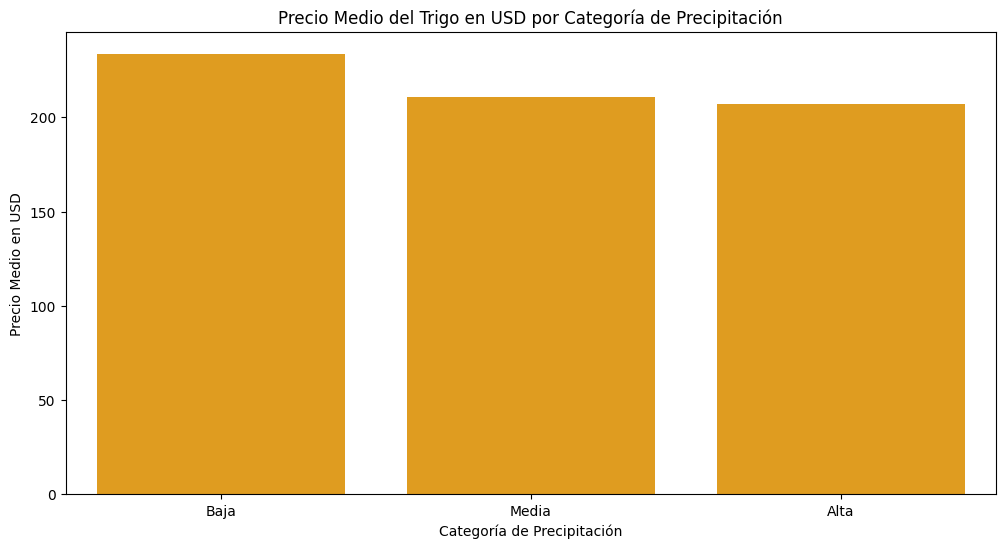

In [16]:
#Se realiza un Gráfico de barras del precio medio del trigo en USD por categoría de precipitación
plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined_final, x='categoria_prcp', y='precio_en_usd', estimator='mean', errorbar=None, color='orange')
plt.title('Precio Medio del Trigo en USD por Categoría de Precipitación')
plt.xlabel('Categoría de Precipitación')
plt.ylabel('Precio Medio en USD')
plt.show()





*Se observa que los precios son bastante similares en las tres categorías de precipitación. Sin embargo, se puede notar una ligera tendencia hacia un precio medio más alto en la categoría de Baja precipitación, lo que sugiere que hay menos oferta disponible en el mercado. Las condiciones de baja precipitación pueden limitar la producción del trigo, lo que a su vez puede llevar a un aumento en los precios debido a la ley de oferta y demanda.*


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



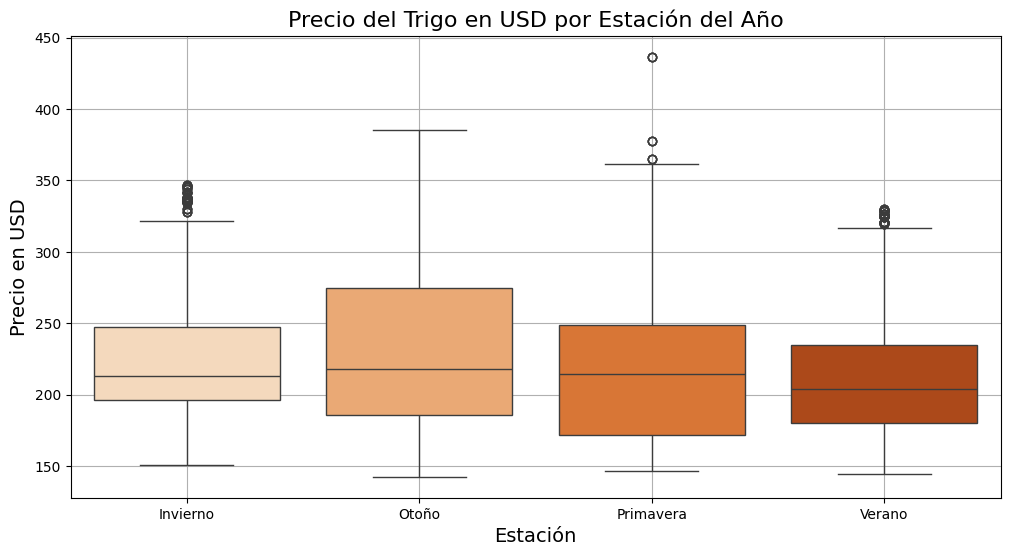

In [17]:
# boxplot del precio del trigo en USD por estación del año
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined_final, x='estacion', y='precio_en_usd', palette='Oranges')
plt.title('Precio del Trigo en USD por Estación del Año', fontsize=16)
plt.xlabel('Estación', fontsize=14)
plt.ylabel('Precio en USD', fontsize=14)
plt.grid()
plt.show()



*Se observa que los precios del trigo son los más bajos en verano y más altos en otoño. Este patrón se puede explicar porque en temperaturas altas y la falta de precipitaciones el trigo entra en estres hidrico, lo que afecta la caliad del trigo y reduce su precio en consecuencia. Ademas, por la dinámica de la oferta y la demanda en el mercado. Durante la primavera y principios del verano, se produce la mayoria de la cosecha del trigo, lo que resulta en una mayor disponibilidad del producto en el mercado. Esta abundancia tiende a aumentar la oferta, lo que generalmente presiona a la baja los precios. Por otro lado, en otoño, la oferta de trigo disminuye ya que los cultivos están en proceso de siembra, lo que provoca un incremento en los precios debido a la menor disponibilidad del producto en comparación con la demanda existente.*

In [18]:
#Se realiza el proceso para interpretar los outliers
Q1 = df_combined_final['precio_en_usd'].quantile(0.25)
Q3 = df_combined_final['precio_en_usd'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_combined_final[(df_combined_final['precio_en_usd'] < limite_inferior) |
                              (df_combined_final['precio_en_usd'] > limite_superior)]
print("Outliers identificados:")
print(outliers)


Outliers identificados:
          fecha  precio     usd_ars  precio_en_usd  precio_petroleo  \
5128 2022-04-18   39500  113.833351     346.998482       106.000000   
5129 2022-04-18   39500  113.833351     346.998482       106.000000   
5130 2022-04-18   39500  113.833351     346.998482       106.000000   
5131 2022-04-18   39500  113.833351     346.998482       106.000000   
5132 2022-04-19   40250  114.175934     352.526129       102.099998   
...         ...     ...         ...            ...              ...   
6747 2023-12-11  130000  364.432220     356.719282        70.349998   
6752 2023-12-13  160000  366.471985     436.595447        67.709999   
6753 2023-12-13  160000  366.471985     436.595447        67.709999   
6754 2023-12-13  160000  366.471985     436.595447        67.709999   
6755 2023-12-13  160000  366.471985     436.595447        67.709999   

      precio_global  tavg  tmin  tmax  prcp   wdir  wspd    pres  \
5128        1120.50  19.0  17.1  21.0   0.8   76.0  16.

*La mayoria de los outliers son esperados, y parecen darse en los cambios abruptos en el tipo de cambio, como en diciembre 2023 cuando hubo un cambio de politicas en Argentina lo que generó una alta volatilidad en el mercado cambiario.*

<Figure size 1200x600 with 0 Axes>

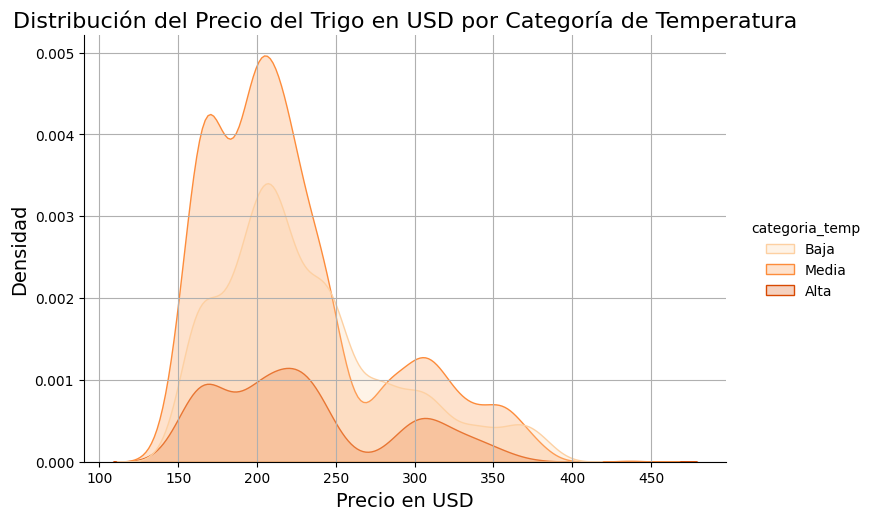

In [19]:

plt.figure(figsize=(12, 6))
sns.displot(data=df_combined_final, x='precio_en_usd', hue='categoria_temp', kind='kde', fill=True, aspect=1.5, palette='Oranges')
plt.title('Distribución del Precio del Trigo en USD por Categoría de Temperatura', fontsize=16)
plt.xlabel('Precio en USD', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.grid()
plt.show()


*La distribución para las altas temperaturas presenta un patrón interesante. Se observa nuevamente que los precios del trigo tienden a ser más bajos en esta categoría. La densidad alcanza su pico en el rango inferior de precios, indicando que en condiciones de altas temperaturas, el precio del trigo suele ser más bajo, por otro lado, en temperaturas medias, el precio tiende a subir,alcanzando picos más altos en comparación con la categoría baja.*

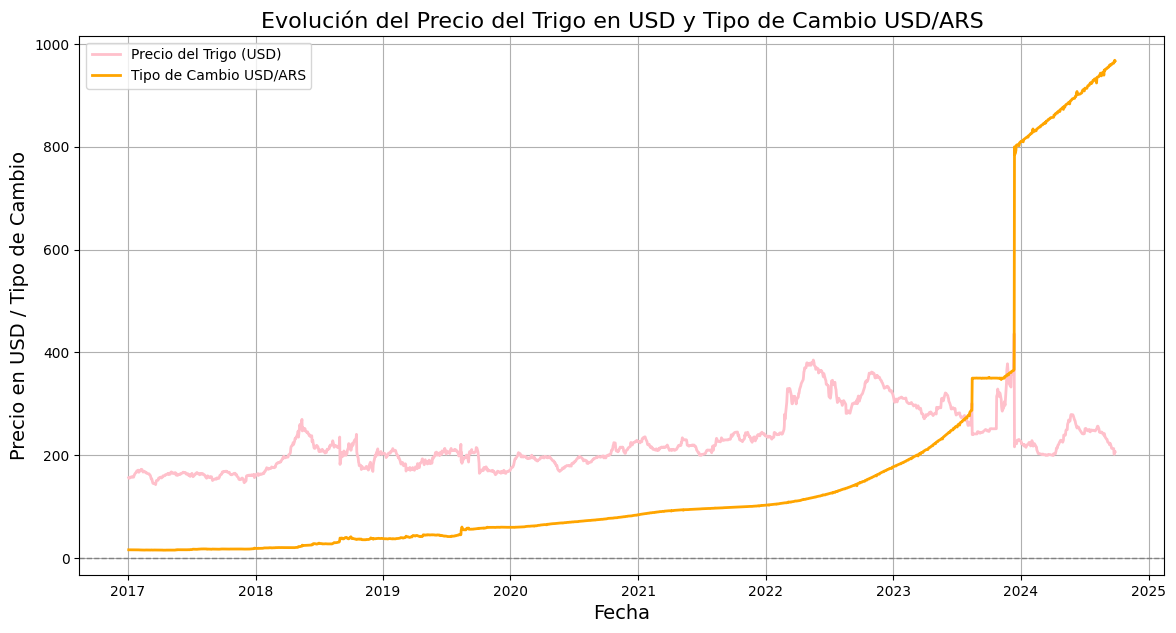

In [20]:

#Se grafican el precio del trigo en usd y el tipo de cambio

plt.figure(figsize=(14, 7))
plt.plot(df_combined_final['fecha'], df_combined_final['precio_en_usd'], label='Precio del Trigo (USD)', color='pink', linewidth=2)
plt.plot(df_combined_final['fecha'], df_combined_final['usd_ars'], label='Tipo de Cambio USD/ARS', color='orange', linewidth=2)

plt.title('Evolución del Precio del Trigo en USD y Tipo de Cambio USD/ARS', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio en USD / Tipo de Cambio', fontsize=14)
plt.axhline(0, color='grey', lw=1, ls='--')
plt.legend()
plt.grid()
plt.show()




*La relación entre ambas líneas sugiere que a medida que el tipo de cambio USD/ARS aumenta (es decir, el peso se debilita), el precio del trigo en USD tiende a fluctuar*

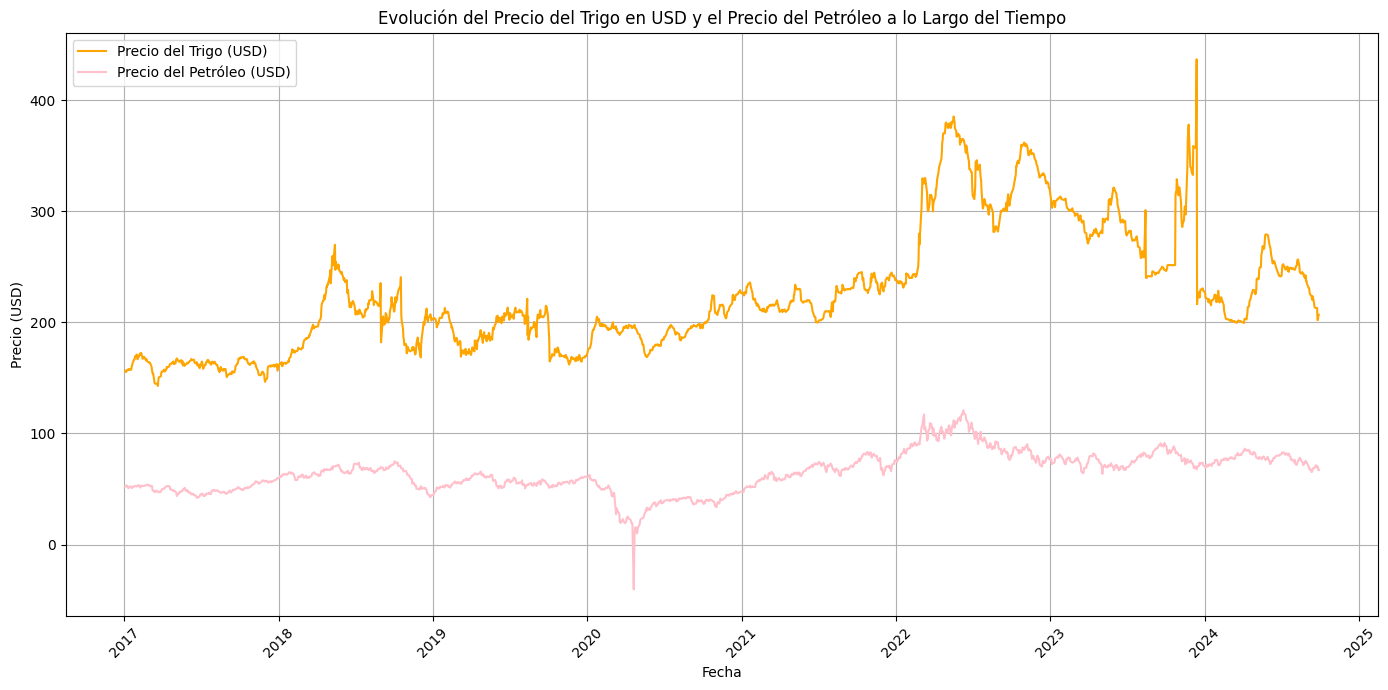

In [21]:
#comparacion entre el precio del trigo en usd y el valor del petroleo a lo largo del tiempo
df_combined_final = df_combined_final[df_combined_final['precio_en_usd'] != 0]
plt.figure(figsize=(14, 7))
plt.plot(df_combined_final['fecha'], df_combined_final['precio_en_usd'], label='Precio del Trigo (USD)', color='orange')
plt.plot(df_combined_final['fecha'], df_combined_final['precio_petroleo'], label='Precio del Petróleo (USD)', color='pink')
plt.title('Evolución del Precio del Trigo en USD y el Precio del Petróleo a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



*La interacción entre el precio del trigo y el petróleo es notable. Aunque el precio del petróleo tiende a ser más estable, se puede observar que las fluctuaciones en el costo del petróleo afectan significativamente el valor del trigo. Esto sugiere que cambios en el precio del petróleo, que impactan los costos de producción y transporte, pueden tener un efecto directo en el precio del trigo en el mercado.*

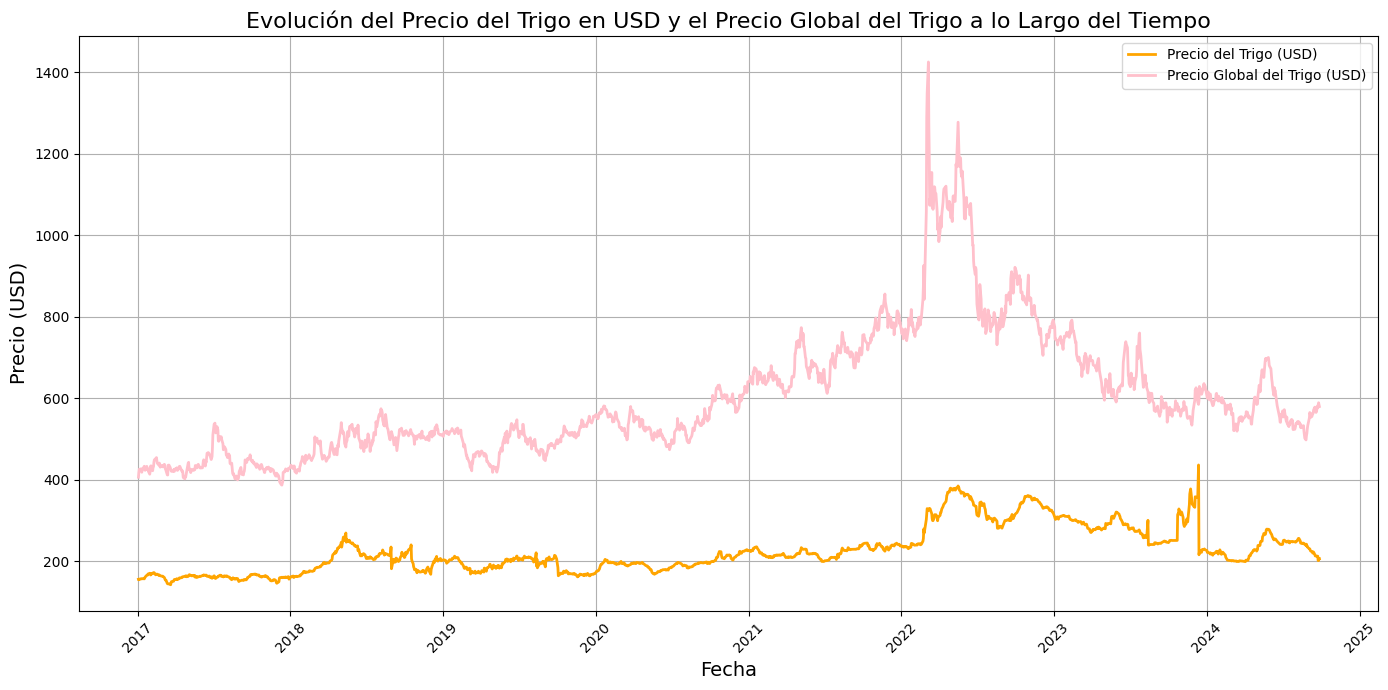

In [22]:
#Se Grafica el precio del trigo en USD contra el precio global del trigo
plt.figure(figsize=(14, 7))
plt.plot(df_combined_final['fecha'], df_combined_final['precio_en_usd'], label='Precio del Trigo (USD)', color='orange', linewidth=2)
plt.plot(df_combined_final['fecha'], df_combined_final['precio_global'], label='Precio Global del Trigo (USD)', color='pink', linewidth=2)
plt.title('Evolución del Precio del Trigo en USD y el Precio Global del Trigo a lo Largo del Tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio (USD)', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


*Se observa que ambos precios presentan una tendencia general similar, con picos y caídas que se correlacionan en momentos específicos. Esto indica que los precios locales del trigo en Argentina están influenciados por el precio global del trigo*

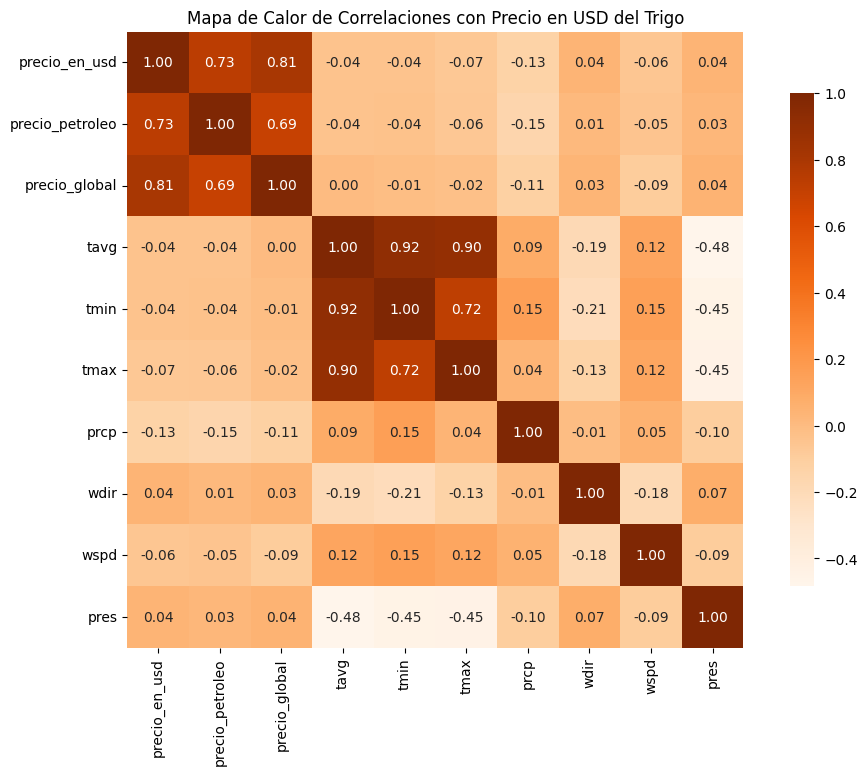

In [23]:
#Matriz de correlación con el mapa de calor
df_filtered = df_combined_final[['precio_en_usd', 'precio_petroleo', 'precio_global', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]
correlation_matrix = df_filtered.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Mapa de Calor de Correlaciones con Precio en USD del Trigo")
plt.show()



A traves de la matriz de correlacion se confirman los factores influentes para el precio del trigo:

**Tipo de Cambio (USD/ARS):** Se detecta una correlación muy fuerte entre el precio del trigo y el tipo de cambio, lo que indica que un aumento en el tipo de cambio (devaluación del peso argentino) está asociado con un aumento en el precio del trigo.*

**Precio en USD y Precio Global del Trigo:** Se observa una fuerte correlación positiva (0.806) entre el precio en USD del trigo en Argentina y el precio global del trigo, sugiriendo que ambos precios tienden a moverse en la misma dirección.

**Precio del Petróleo**: La correlación entre el precio del trigo y el precio del petróleo es también positiva, indicando que el precio del petróleo influye en los costos de producción y por ende en el precio del trigo.

**Temperaturas:** Las temperaturas mínimas (tmin) y máximas (tmax) muestran correlaciones positivas moderadas con el precio del trigo. Esto sugiere que temperaturas más altas podrían estar asociadas con precios más bajos del trigo tal como se observó en graficos anteriores, posiblemente debido a condiciones de estrés en el cultivo u oferta y demanda por epocas de cosecha.

**Precipitación (prcp):** La precipitación también tiene una correlación negativa con el precio del trigo (-0.109), lo que implica que una mayor cantidad de precipitación puede asociarse con precios más bajos

# **Conclusion EDA**
# Este analisis revela que el precio del trigo en Argentina está fuertemente influenciado por varios factores. La influencia del tipo de cambio indica que la devaluación del peso aumenta el precio del trigo en dolar. Además, existe una fuerte relación con el precio global del trigo y el precio del petróleo, lo que sugiere que los costos de producción y las condiciones del mercado internacional son cruciales. Las condiciones climaticas como temperaturas y precipitación son influentes afectando el precio a la baja en condiciones extremas de calor o sequia. Con esta información, podemos prodecer a realizar modelos que intenten predecir el precio del trigo.

# **Modelado y prediccion**

Se utilizarán dos modelos de regresión para comparar y decidir cual comete menos errores al predecir el precio del trigo.

In [24]:
import numpy as np

precio_columns = ['precio_en_usd', 'precio_petroleo', 'precio_global']
for col in precio_columns:
    if col in df_combined_final.columns:
        #Se aplica logaritmo a las columnas de precios (con +1 para evitar log(0))
        df_combined_final[f'log_{col}'] = np.log(df_combined_final[col] + 1)
print(df_combined_final[['precio_en_usd', 'log_precio_en_usd', 'precio_petroleo', 'log_precio_petroleo', 'precio_global', 'log_precio_global']].head())


   precio_en_usd  log_precio_en_usd  precio_petroleo  log_precio_petroleo  \
4     156.264711           5.057930        52.110001             3.972365   
5     156.264711           5.057930        52.110001             3.972365   
6     156.264711           5.057930        52.110001             3.972365   
7     156.264711           5.057930        52.110001             3.972365   
8     156.573576           5.059892        52.150002             3.973118   

   precio_global  log_precio_global  
4          406.5           6.010041  
5          406.5           6.010041  
6          406.5           6.010041  
7          406.5           6.010041  
8          418.5           6.039064  


Dado que existen varios outliers/datos atipicos debido a saltos en el tipo de cambio argentino (por cambios sociopoliticos y macro economicos), se transformaran todas las variables -relacionadas con precios- logaritmicamente para así reducir sesgos mientras se mantiene la escala relativa en los precios.




In [25]:
import pandas as pd
import numpy as np


#Se codifican las variables categóricas relevantes usando pd.get_dummies (One-Hot Encoding)
df_encoded = df_combined_final.copy()
categoricas_relevantes = ['categoria_prcp', 'categoria_temp', 'estacion']
df_encoded = pd.get_dummies(df_encoded, columns=categoricas_relevantes, drop_first=True)
print(df_encoded.head())

relevant_columns = ['log_precio_en_usd', 'log_precio_petroleo', 'log_precio_global',
                    'categoria_prcp_Media', 'categoria_prcp_Alta',
                    'categoria_temp_Media', 'categoria_temp_Alta',
                    'estacion_Otoño', 'estacion_Primavera', 'estacion_Verano',
                    'tmin', 'tmax', 'tavg']  # Incluir las columnas de temperatura

#DataFrame final con solo las columnas relevantes
df_final = df_encoded[relevant_columns]
# valores nulos hay en cada columna de df_final
null_values = df_final.isnull().sum()
# DataFrame final
print(df_final.head())
#Se interpolan los valores nulos en 'log_precio_petroleo' utilizando interpolación lineal
df_final['log_precio_petroleo'] = df_final['log_precio_petroleo'].interpolate(method='linear')
print("\nValores nulos después de la interpolación:")
print(df_final['log_precio_petroleo'].isnull().sum())


       fecha  precio  usd_ars  precio_en_usd  precio_petroleo  precio_global  \
4 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
5 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
6 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
7 2017-01-03    2490  15.9345     156.264711        52.110001          406.5   
8 2017-01-04    2495  15.9350     156.573576        52.150002          418.5   

   tavg  tmin  tmax       prcp  ...  log_precio_en_usd  log_precio_petroleo  \
4  26.1  23.6  28.3   8.571429  ...           5.057930             3.972365   
5  28.5  21.7  38.2   0.000000  ...           5.057930             3.972365   
6  26.0  22.1  31.3  23.100000  ...           5.057930             3.972365   
7  23.5  17.4  33.4  11.900000  ...           5.057930             3.972365   
8  26.1  22.2  30.9  12.857143  ...           5.059892             3.973118   

   log_precio_global categoria_prcp_Media  c

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# **Entrenamiento y evaluacion de los modelos elegidos (ridge regression y Random forest)**

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#Se definen X (las variables predictoras) y y (la variable objetivo)
X = df_final.drop(columns=['log_precio_en_usd'])  # Eliminamos la columna objetivo de X
y = df_final['log_precio_en_usd']  # La columna objetivo es log_precio_en_usd

#datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ridge_model = Ridge(alpha=0.01)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modelo Ridge Regression
ridge_model.fit(X_train, y_train)
y_pred_log_ridge = ridge_model.predict(X_test)
y_pred_original_ridge = np.exp(y_pred_log_ridge) - 1  # Inversión logaritmo
y_test_original = np.exp(y_test) - 1  # Inversión logaritmo

ridge_mse = mean_squared_error(y_test_original, y_pred_original_ridge)
ridge_mae = mean_absolute_error(y_test_original, y_pred_original_ridge)
ridge_r2 = r2_score(y_test_original, y_pred_original_ridge)

# Modelo Random Forest
rf_model.fit(X_train, y_train)
y_pred_log_rf = rf_model.predict(X_test)
y_pred_original_rf = np.exp(y_pred_log_rf) - 1  # Inversión logaritmo

rf_mse = mean_squared_error(y_test_original, y_pred_original_rf)
rf_mae = mean_absolute_error(y_test_original, y_pred_original_rf)
rf_r2 = r2_score(y_test_original, y_pred_original_rf)

# Resultados en conjunto de prueba
test_results_no_pca = pd.DataFrame({
    "Model": ["Ridge Regression", "Random Forest"],
    "MSE (Test)": [ridge_mse, rf_mse],
    "MAE (Test)": [ridge_mae, rf_mae],
    "R2 (Test)": [ridge_r2, rf_r2]
})

print("\nResultados en Conjunto de Prueba:")
print(test_results_no_pca)



Resultados en Conjunto de Prueba:
              Model  MSE (Test)  MAE (Test)  R2 (Test)
0  Ridge Regression  824.920964   20.835686   0.726058
1     Random Forest   98.970652    4.561570   0.967134


En estos primeros resultados se puede observar que el MSE de random forest es mucho más bajo (98.97) (contra  824 ridge) y el MAE también es significativamente menor (4.56), contra 20.8 ridge. Lo que indica que tiene un mejor rendimiento en términos de precisión. Además, el R² de 0.97 (contra 0.72) muestra que el modelo explica el 97% de la variabilidad en los datos, lo que indica un rendimiento excelente y un modelo más adecuado para las predicciones.

# **Validacion cruzada y PCA**

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#Se crea un método para realizar validación cruzada con múltiples métricas
def cross_validate_model(model, X, y, cv=5):
    # Configurar las métricas
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    #Se valida con MSE
    mse_scores = cross_val_score(model, X, y, cv=cv, scoring=mse_scorer)
    mae_scores = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer)

    # métricas
    results = {
        "MSE (Mean)": -np.mean(mse_scores),
        "MSE (Std Dev)": np.std(mse_scores),
        "MAE (Mean)": -np.mean(mae_scores),
        "MAE (Std Dev)": np.std(mae_scores),
        "R2 (Std Dev)": np.std(r2_scores)
    }
    return results

ridge_model = Ridge(alpha=0.1)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

ridge_cv_results = cross_validate_model(ridge_model, X, y, cv=5)

rf_cv_results = cross_validate_model(rf_model, X, y, cv=5)

# Mostrar resultados de validación cruzada
cv_results = pd.DataFrame([ridge_cv_results, rf_cv_results], index=["Ridge Regression", "Random Forest"])
print("\nResultados de Validación Cruzada:")
print(cv_results)



Resultados de Validación Cruzada:
                  MSE (Mean)  MSE (Std Dev)  MAE (Mean)  MAE (Std Dev)  \
Ridge Regression    0.021627       0.008902    0.117078       0.023036   
Random Forest       0.029212       0.008012    0.142197       0.020785   

                  R2 (Std Dev)  
Ridge Regression      1.817929  
Random Forest         0.933591  


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Se escalan las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Se Aplica PCA para reducir la dimensionalidad (y evitar sobreajustes)
pca = PCA(n_components=0.95)  # Retener el 95% de la variabilidad
X_pca = pca.fit_transform(X_scaled)

#Se dividen los datos en entrenamiento y prueba
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

#Modelo Ridge Regression
ridge_model.fit(X_train_pca, y_train)
y_pred_log_ridge_pca = ridge_model.predict(X_test_pca)
y_pred_original_ridge_pca = np.exp(y_pred_log_ridge_pca) - 1
y_test_original = np.exp(y_test) - 1

ridge_mse_pca = mean_squared_error(y_test_original, y_pred_original_ridge_pca)
ridge_mae_pca = mean_absolute_error(y_test_original, y_pred_original_ridge_pca)
ridge_r2_pca = r2_score(y_test_original, y_pred_original_ridge_pca)

#Modelo Random Forest
rf_model.fit(X_train_pca, y_train)
y_pred_log_rf_pca = rf_model.predict(X_test_pca)
y_pred_original_rf_pca = np.exp(y_pred_log_rf_pca) - 1

rf_mse_pca = mean_squared_error(y_test_original, y_pred_original_rf_pca)
rf_mae_pca = mean_absolute_error(y_test_original, y_pred_original_rf_pca)
rf_r2_pca = r2_score(y_test_original, y_pred_original_rf_pca)

#Resultados en conjuntos de prueba
test_results_pca = pd.DataFrame({
    "Model": ["Ridge Regression (PCA)", "Random Forest (PCA)"],
    "MSE (Test)": [ridge_mse_pca, rf_mse_pca],
    "MAE (Test)": [ridge_mae_pca, rf_mae_pca],
    "R2 (Test)": [ridge_r2_pca, rf_r2_pca]
})

print("\nResultados en Conjunto de Prueba con PCA:")
print(test_results_pca)



Resultados en Conjunto de Prueba con PCA:
                    Model  MSE (Test)  MAE (Test)  R2 (Test)
0  Ridge Regression (PCA)  830.734224   21.282190   0.724128
1     Random Forest (PCA)  335.982376   11.125631   0.888426


Random Forest con PCA sigue funcionando mejor que Ridge Regression.Aunque parece haberse sensibilizado por la reduccion de dimensionalidad, tiene un MSE mucho más bajo, un MAE más bajo, y un R² mucho más alto.
Random Forest es más robusto y captura mejor las relaciones no lineales en los datos, lo que lo hace más adecuado para este conjunto de datos.

In [29]:
# Validación cruzada con PCA
ridge_cv_scores = cross_val_score(ridge_model, X_pca, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_scores = cross_val_score(rf_model, X_pca, y, cv=5, scoring='neg_mean_squared_error')


print("\nResultados de Validación Cruzada con PCA (Ridge Regression):")
print(f"MSE (CV mean): {-ridge_cv_scores.mean()}, Std Dev: {ridge_cv_scores.std()}")

print("\nResultados de Validación Cruzada con PCA (Random Forest):")
print(f"MSE (CV mean): {-rf_cv_scores.mean()}, Std Dev: {rf_cv_scores.std()}")


Resultados de Validación Cruzada con PCA (Ridge Regression):
MSE (CV mean): 0.02218557461480744, Std Dev: 0.009209177873438043

Resultados de Validación Cruzada con PCA (Random Forest):
MSE (CV mean): 0.03128252859537276, Std Dev: 0.012269394724801671


Ridge Regression con pca y validacion cruzada parece ser ligeramente más estable y mejor en cuanto a MSE, mientras que Random Forest puede ser más sensible a las fluctuaciones en los datos, pero ambos modelos tienen una capacidad decente de predicción en este contexto

# **Ajuste de hiper parametros**

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#parámetros a ajustar
rf_params = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  #
    'max_features': ['auto', 'sqrt', 'log2']
}

#Se utiliza RandomizedSearchCV
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rf_random_search.fit(X, y)

#Mejor combinación de hiperparámetros
print("Mejores parámetros de Random Forest:", rf_random_search.best_params_)
print("Mejor puntuación MSE (negativo):", rf_random_search.best_score_)

#Se entrena el modelo con los mejores parámetros
best_rf_model = rf_random_search.best_estimator_

#Se evalua el modelo
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nDesempeño en Conjunto de Prueba (Random Forest ajustado):")
print(f"MSE: {mse_rf:.6f}")
print(f"MAE: {mae_rf:.6f}")
print(f"R2: {r2_rf:.6f}")

#Se calcula tambien el MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn

Mejores parámetros de Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Mejor puntuación MSE (negativo): -0.025717324476771792

Desempeño en Conjunto de Prueba (Random Forest ajustado):
MSE: 0.003538
MAE: 0.041764
R2: 0.932247
RMSE: 0.05947852231442634


 El modelo Random Forest ha demostrado un excelente desempeño con el ajuste de hiper parametros utilizado.
El R² de 0.93 es una señal de que el modelo captura bien la relación entre las variables predictoras y el precio del trigo.
Los valores de MSE y RMSE son muy bajos, lo que indica que el modelo tiene errores pequeños y es preciso.
El MAE también es bajo, confirmando la precisión del modelo en cuanto a la magnitud de los errores.

# **CONCLUSIÓN**

 El modelo de Random Forest fue seleccionado debido **a su rendimiento superior** en comparación con Ridge Regression en términos de precisión (MSE y MAE más bajos) y capacidad de explicación (R² más alto). A pesar de que ridge mostro un ajuste aceptable, Random Forest demostró ser más eficaz para capturar la complejidad de los datos y asi lograr **predecir el precio del trigo** dentro de los conjuntos de datos brindados.